In [ ]:
!pip install --upgrade kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")

print("Path to dataset files:", path)

100%|██████████| 262M/262M [00:05<00:00, 49.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/austinreese/craigslist-carstrucks-data/versions/10


In [ ]:
# Installation
!pip install -q pandas numpy scikit-learn matplotlib seaborn

In [ ]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
used_cars = pd.read_csv(os.path.join(path, 'vehicles.csv'))


In [ ]:
used_cars['price'] = pd.to_numeric(used_cars['price'], errors='coerce')
used_cars['year'] = pd.to_numeric(used_cars['year'], errors='coerce')
used_cars['odometer'] = pd.to_numeric(used_cars['odometer'], errors='coerce')

In [ ]:
categorical_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'transmission', 'type', 'paint_color', 'title_status', 'state']
used_cars[categorical_cols] = used_cars[categorical_cols].astype('category')

In [ ]:
columns_to_drop = ['id', 'url', 'region', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long']
used_cars = used_cars.drop(columns=columns_to_drop)

In [ ]:
used_cars['posting_date'] = pd.to_datetime(used_cars['posting_date'], utc=True)

In [ ]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   price         426880 non-null  int64              
 1   year          425675 non-null  float64            
 2   manufacturer  409234 non-null  category           
 3   model         421603 non-null  category           
 4   condition     252776 non-null  category           
 5   cylinders     249202 non-null  category           
 6   fuel          423867 non-null  category           
 7   odometer      422480 non-null  float64            
 8   title_status  418638 non-null  category           
 9   transmission  424324 non-null  category           
 10  drive         296313 non-null  object             
 11  size          120519 non-null  object             
 12  type          334022 non-null  category           
 13  paint_color   296677 non-null  category     

In [ ]:
# Assuming 'data' is your DataFrame
price_stats = used_cars['price'].describe()
print(price_stats)


count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64


In [ ]:
import numpy as np
from scipy.stats import mannwhitneyu

# Your dataset
data = used_cars

# Step 1: Create missing value indicators for each feature
missing_indicators = used_cars.isnull().astype(int).add_suffix('_missing')

# Concatenate the indicators with the original data
data_with_indicators = pd.concat([data, missing_indicators], axis=1)

# Step 2: Hypothesis testing and correlation analysis
results = {}

for feature in data.columns:
    if data[feature].isnull().any():  # Check if feature has missing values
        # Create subsets for missing and non-missing values
        subset_missing = data_with_indicators[data_with_indicators[feature + '_missing'] == 1]['price']
        subset_present = data_with_indicators[data_with_indicators[feature + '_missing'] == 0]['price']

        # Perform Mann-Whitney U test
        statistic, p_value = mannwhitneyu(subset_missing, subset_present)


        correlation = data_with_indicators[feature + '_missing'].corr(data_with_indicators['price'])
        # Store results
        results[feature] = {
            'statistic': statistic,
            'p_value': p_value,
            'correlation': correlation
        }

# Print results
for feature, result in results.items():
    print(f"Feature: {feature}")
    print(f"Mann-Whitney U statistic: {result['statistic']}")
    print(f"P-value: {result['p_value']}")
    print(f"Correlation with 'price': {result['correlation']}\n")




Feature: year
Mann-Whitney U statistic: 404672922.5
P-value: 7.143240704129436e-264
Correlation with 'price': -0.00016448016397093985

Feature: manufacturer
Mann-Whitney U statistic: 3449984932.5
P-value: 1.1496127388818606e-23
Correlation with 'price': -0.0007104359065728912

Feature: model
Mann-Whitney U statistic: 940770810.5
P-value: 5.7265343766695715e-83
Correlation with 'price': 0.01042241125762487

Feature: condition
Mann-Whitney U statistic: 20669074538.5
P-value: 6.974539610616671e-250
Correlation with 'price': 0.0015220864665589082

Feature: cylinders
Mann-Whitney U statistic: 23912486092.5
P-value: 0.0
Correlation with 'price': 0.0008768493201015051

Feature: fuel
Mann-Whitney U statistic: 655396798.0
P-value: 0.012448437335439646
Correlation with 'price': -0.000397708870594226

Feature: odometer
Mann-Whitney U statistic: 523412465.0
P-value: 0.0
Correlation with 'price': -0.0005514031075180616

Feature: title_status
Mann-Whitney U statistic: 1518599260.5
P-value: 1.1930033

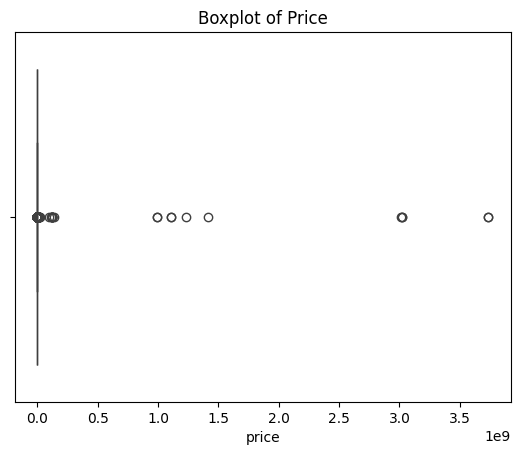

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
# Enable IterativeImputer before importing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Your dataset
data = used_cars

# Step 1: Analyze Outliers

# a) Visualize outliers
sns.boxplot(x='price', data=data)
plt.title('Boxplot of Price')
plt.show()

sns.histplot(data['price'], kde=True)
plt.title('Histogram of Price')
plt.show()

In [ ]:
# b) KNN or Iterative Imputer for missingness between 20% and 40%
features_to_impute = []
for feature in data.columns:
    missing_percentage = data[feature].isnull().mean() * 100
    if 20 <= missing_percentage <= 40:
        features_to_impute.append(feature)

imputer = KNNImputer(n_neighbors=5)  # Adjust n_neighbors as needed
data[features_to_impute] = imputer.fit_transform(data[features_to_impute])


imputer = IterativeImputer()  # You can specify an estimator, e.g., RandomForestRegressor
data[features_to_impute] = imputer.fit_transform(data[features_to_impute])


In [ ]:

# c) Mode Imputation or "Unknown" Category for categorical data
for column in data.select_dtypes(include='object').columns:
    missing_percentage = data[column].isnull().mean() * 100
    if missing_percentage < 20:
        data[column].fillna(data[column].mode().iloc[0], inplace=True)
    else:
        data[column].fillna('Unknown', inplace=True)

# d) Feature Removal
features_to_remove = []
for feature in data.columns:
    missing_percentage = data[feature].isnull().mean() * 100
    if missing_percentage > 40 and abs(results[feature]['correlation']) < 0.2:
        features_to_remove.append(feature)

data = data.drop(columns=features_to_remove)

# Step 4: Evaluate Imputation Strategies
# ... (train and evaluate models on different imputed datasets)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming 'data' is your DataFrame with imputed values

# Split data into features (X) and target (y)
X = data.drop('price', axis=1)  # Replace 'price' with your target variable
y = data['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list to store results for different imputation strategies
results = []

# Evaluate different imputation strategies
imputation_strategies = {
    'Mean Imputation': data,  # Original data with mean imputation
    'KNN Imputation': data,  # Data with KNN imputation (if applied)
    'Iterative Imputation': data,  # Data with Iterative Imputation (if applied)
    # Add more strategies as needed
}

for strategy_name, imputed_data in imputation_strategies.items():
    # Select features and target for the current strategy
    X_strategy = imputed_data.drop('price', axis=1)
    y_strategy = imputed_data['price']

    # Split data for the current strategy
    X_train_strategy, X_test_strategy, y_train_strategy, y_test_strategy = train_test_split(
        X_strategy, y_strategy, test_size=0.2, random_state=42
    )

    # Train a Linear Regression model
    model = LinearRegression()
    model.fit(X_train_strategy, y_train_strategy)

    # Make predictions on the test set
    y_pred = model.predict(X_test_strategy)

    # Evaluate the model using Mean Squared Error
    mse = mean_squared_error(y_test_strategy, y_pred)

    # Store the results
    results.append({'strategy': strategy_name, 'mse': mse})

# Print the results
for result in results:
    print(f"Imputation Strategy: {result['strategy']}, MSE: {result['mse']}")